# Load and inspect dataset structure

In [1]:
import warnings

#Ignore seaborn's countplot warning (when not specifying an order)
warnings.filterwarnings("ignore", message = "^.*countplot.*order")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from src.eda_utils import salary_per_category_table, salary_per_category_plot, PlotStats, faceted_histogram_plot

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9.6, 7.2)

In [3]:
train_features = pd.read_csv('../data/raw/train_features.csv')
train_salaries = pd.read_csv('../data/raw/train_salaries.csv')

In [4]:
print(f'Training features shape: {train_features.shape}')
print(f'Training salaries shape: {train_salaries.shape}')

Training features shape: (1000000, 8)
Training salaries shape: (1000000, 2)


In [5]:
train_features.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


Check how many different values there are for the categorical variables

In [6]:
train_features[['companyId', 'jobType', 'degree', 'major', 'industry']].nunique()

companyId    63
jobType       8
degree        5
major         9
industry      7
dtype: int64

In [7]:
train_features.major.value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

# Join salary and job description features

In [8]:
salaries_all = train_features.set_index('jobId').join(train_salaries.set_index('jobId'))
salaries_all.reset_index(inplace=True)
salaries_all.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


Check for missing values after joining datasets

In [9]:
salaries_all.apply(lambda x: sum(x.isna()))

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [10]:
salaries_all.shape

(1000000, 9)

In [11]:
salaries_all.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


Store metrics about the salary variable, for later use

In [12]:
salary_stats = PlotStats(salaries_all, 'salary')

### Check duplicates

In [13]:
any(salaries_all.jobId.duplicated())

False

In [14]:
any(salaries_all.duplicated())

False

# Target - Salary

In [15]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [16]:
print("Salary stats:")
train_salaries.salary.describe()

Salary stats:


count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

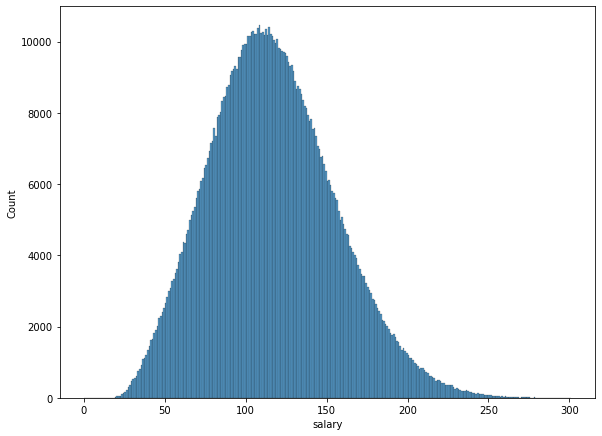

In [17]:
sns.histplot(train_salaries.salary, binwidth = 1)
plt.show()

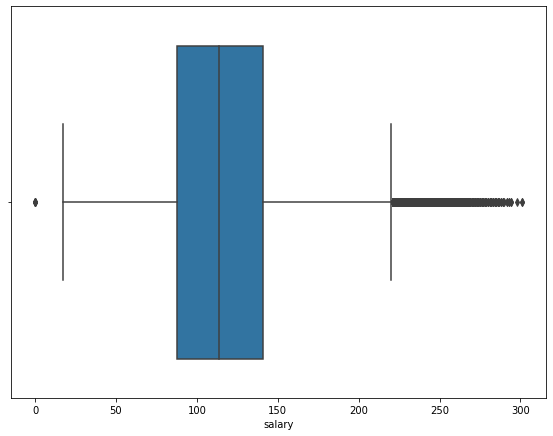

In [18]:
sns.boxplot(x = train_salaries.salary)
plt.show()

### Jobs with zero salary

In [19]:
sum(train_salaries.salary == 0)

5

In [20]:
salaries_all.loc[salaries_all.salary == 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


#### No obvious pattern to jobs with zero salary. 

Jobs with substantial years of experience, or management or higher are especially suspicious.

These data points could indicate errors; something wrong in the upstream data pipeline. Or they could be normal examples that, for some reason, accurately have 0 salary.

Outliers such as these will impact the predicted salary amount. The best course of action would be to confirm the accuracy of the data points and/ or discover the source of a data error.

Approaches to consider, for predictive modeling:  
_(assuming questions about data pipeline health and accuracy of the data can't be answered)_
- Remove them from the data set before training
- Impute salary values to them
- Leave them as is

### Top end salaries

Look into the highest salary values and check for more subtle signs of data quality issues (i.e. extremely high paid junior positions)

In [21]:
# Top 0.5% Of the data 
top_half_percent = train_salaries.salary.quantile(0.995)
sum(train_salaries.salary > top_half_percent)

4856

In [22]:
top_salaries = salaries_all.loc[salaries_all.salary > top_half_percent]
top_salaries_melted = pd.melt(top_salaries[['jobType', 'degree', 'major', 'industry']], value_vars = ['jobType', 'degree', 'major', 'industry'], var_name = 'column')

Countplot of the types of job postings with the top 0.5% salary.  
Faceted by the categorical variables: `jobType`, `degree`, `major`, `industry`.

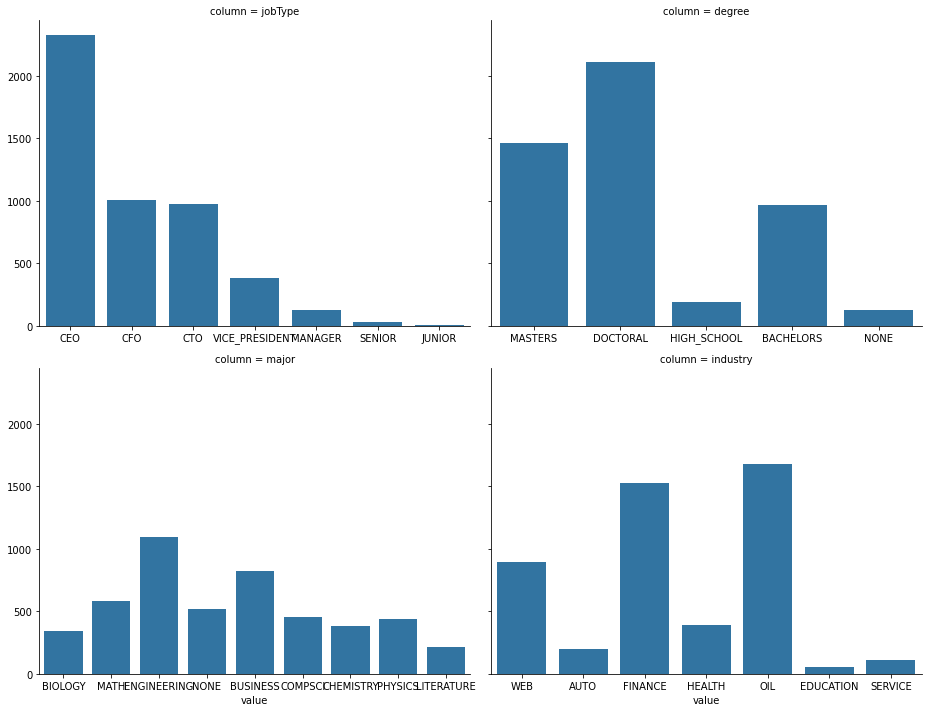

In [23]:
grid = sns.FacetGrid(top_salaries_melted, col = 'column', col_wrap = 2, sharex = False, height = 5, aspect = 1.3)
grid.map(sns.countplot, 'value')
plt.show()

In [24]:
num_top_graduate_degrees = sum(top_salaries.degree.isin(['MASTERS', 'DOCTORAL']))
print(f"{round((num_top_graduate_degrees/top_salaries.shape[0]) * 100, 2)}% of top salaried jobs in the data set have graduate degrees")

73.62% of top salaried jobs in the data set have graduate degrees


There are some very high paying `JUNIOR` jobs, which should be looked at more closely. 

The distributions for other jobTypes, as well as across other columns follow what one would expect.  

Among the top paying jobs, in the data set:  
- There are far more graduate degrees than having a bachelors or lower degrees of education. 
- There are far more c-suite `jobType`'s than `VICE_PRESIDENT` or lower

---
It will still be informative to look more closely at the salary distributions for each of these category breakdowns; incase there are some unexpected underlying distributions 
- _handled below when looking separately at each categorical column._

___

In [25]:
sum(top_salaries.jobType == 'JUNIOR')

7

In [26]:
top_salaries.loc[top_salaries.jobType == 'JUNIOR']

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
743326,JOB1362685151013,COMP14,JUNIOR,DOCTORAL,BUSINESS,FINANCE,19,0,236
787674,JOB1362685195361,COMP43,JUNIOR,DOCTORAL,BUSINESS,FINANCE,18,15,232
796956,JOB1362685204643,COMP30,JUNIOR,MASTERS,BUSINESS,OIL,24,2,228


In [27]:
top_salaries.loc[top_salaries.jobType == 'JUNIOR'].yearsExperience.mean()

21.857142857142858

#### 20 year 'junior' roles

These jobs marked as `JUNIOR` that are within the top 0.5% of all jobs in the data set have on average over 20 years of experience.

If there is an error in the data here, it probably isn't with the salary amount, but rather the labeling of the jobType.

If there is no error in the data here, then there could be opportunity for upstream data pipeline improvements to make `jobType` more granular and specialized.

# Categorical Features

Explore the relationship between salary and the following variables:
- jobType
- degree
- major
- industry

#### Utility functions
 
Helper functions to inspect average salary across different groupings of the categorical features:  

_(Follow link for function definition)_

1. [salary_per_category_table()](https://github.com/scottwiles/salary_prediction/blob/0d9bf55a592badd9afa066c63e7269daad44f186/src/eda_utils.py#L4) - Calculate the mean salary per the specified category and return the resulting dataframe
2. [salary_per_category_plot()](https://github.com/scottwiles/salary_prediction/blob/0d9bf55a592badd9afa066c63e7269daad44f186/src/eda_utils.py#L13) - Plot the average salary per each category using tables generated from the above function



## Salaries per job type

In [28]:
salaries_all.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

Equal distribution of `jobType` categories

In [29]:
avg_salary_per_jobtype = salary_per_category_table('jobType', salaries_all)
avg_salary_per_jobtype

,jobType,salary
0,JANITOR,70.813045
1,JUNIOR,95.331557
2,SENIOR,105.487775
3,MANAGER,115.367596
4,VICE_PRESIDENT,125.367629
5,CFO,135.458547
6,CTO,135.479983
7,CEO,145.311425


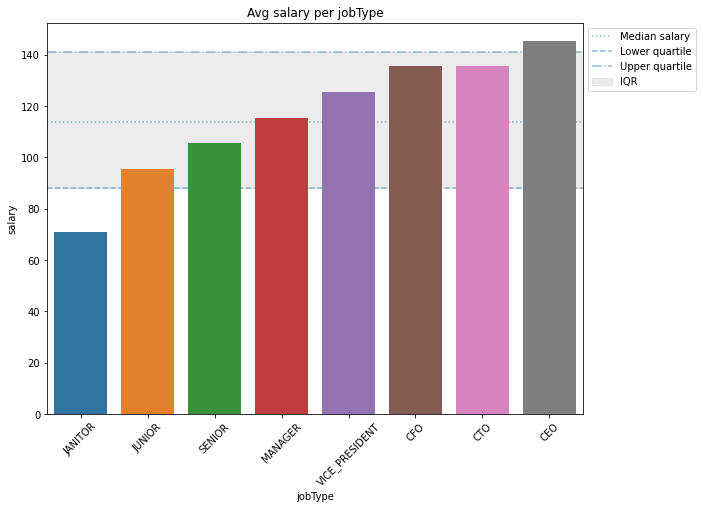

In [30]:
plt.figure()
salary_per_category_plot('jobType', avg_salary_per_jobtype)
salary_stats.plot_IQR()
plt.show()

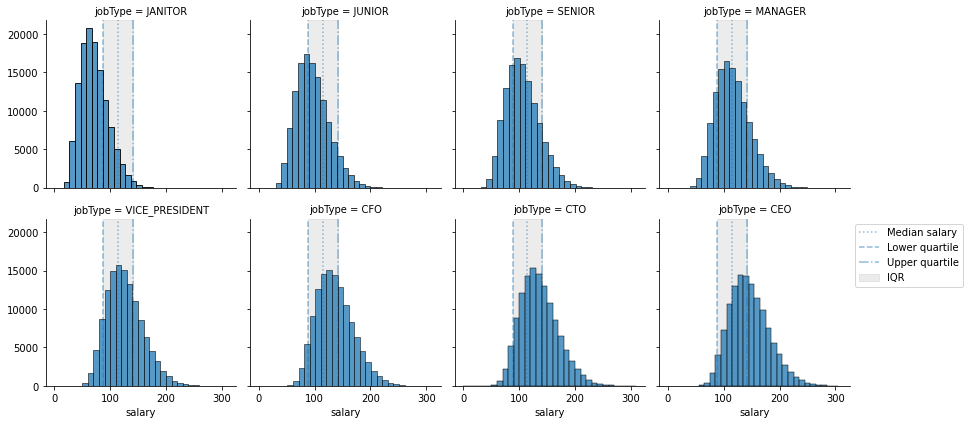

In [32]:
faceted_histogram_plot(salaries_all, 'jobType',
                       grid_kwargs = {'col_wrap': 4, 'col_order': avg_salary_per_jobtype.jobType},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per degree

In [33]:
avg_salary_per_degree = salary_per_category_table('degree', salaries_all)
avg_salary_per_degree

,degree,salary
0,NONE,98.176467
1,HIGH_SCHOOL,101.920654
2,BACHELORS,125.454663
3,MASTERS,130.504903
4,DOCTORAL,135.489433


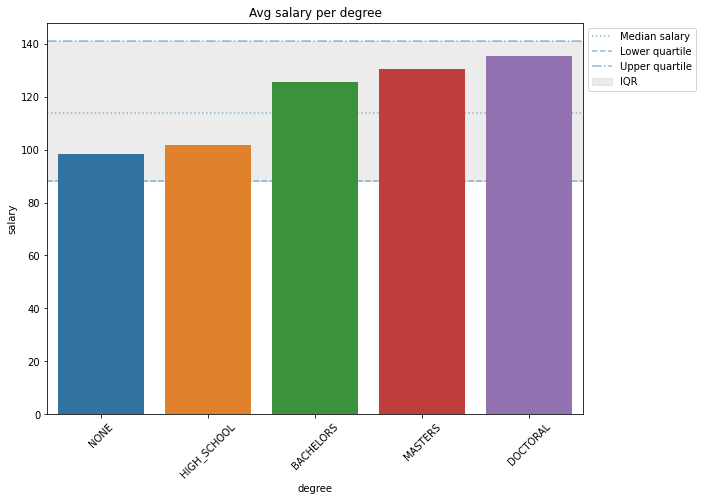

In [34]:
plt.figure()
salary_per_category_plot('degree', avg_salary_per_degree)
salary_stats.plot_IQR()
plt.show()

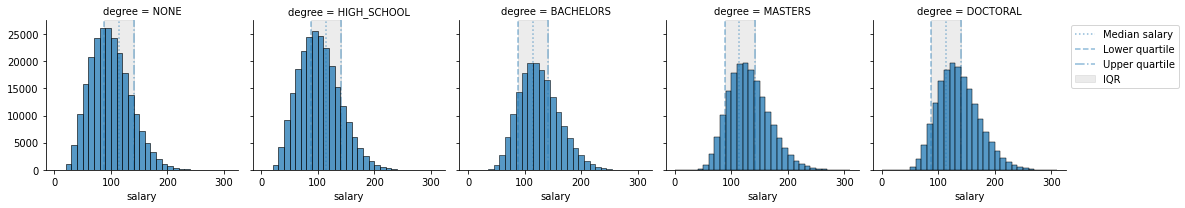

In [35]:
faceted_histogram_plot(salaries_all, 'degree',
                       grid_kwargs = {'col_wrap': 5, 'col_order': avg_salary_per_degree.degree},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per major

In [36]:
avg_salary_per_major = salary_per_category_table('major', salaries_all)
avg_salary_per_major

,major,salary
0,NONE,102.583479
1,LITERATURE,124.423097
2,BIOLOGY,127.932664
3,CHEMISTRY,129.072085
4,PHYSICS,130.372436
5,COMPSCI,132.075605
6,MATH,133.319735
7,BUSINESS,135.648980
8,ENGINEERING,138.436617


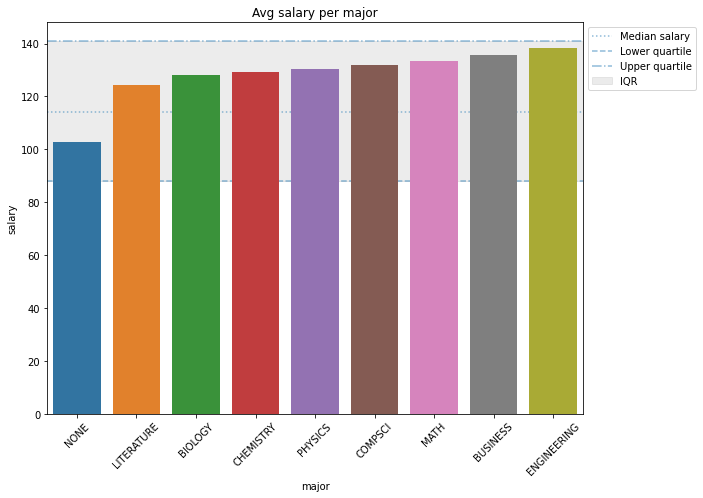

In [37]:
plt.figure()
salary_per_category_plot('major', avg_salary_per_major)
salary_stats.plot_IQR()
plt.show()

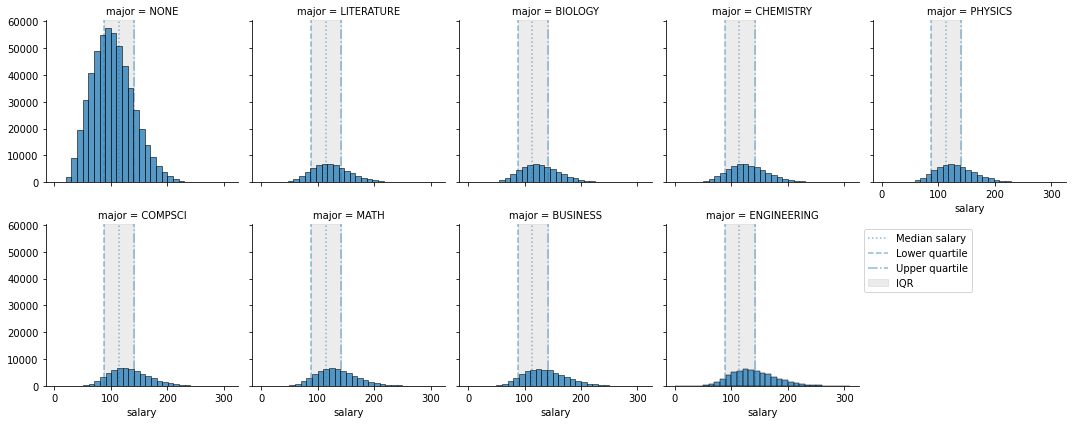

In [38]:
faceted_histogram_plot(salaries_all, 'major',
                       grid_kwargs = {'col_wrap': 5, 'col_order': avg_salary_per_major.major},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per industry

In [39]:
avg_salary_per_industry = salary_per_category_table('industry', salaries_all)
avg_salary_per_industry

,industry,salary
0,EDUCATION,99.448386
1,SERVICE,104.446820
2,AUTO,109.433690
3,HEALTH,115.735540
4,WEB,121.644512
5,FINANCE,130.746743
6,OIL,130.952946


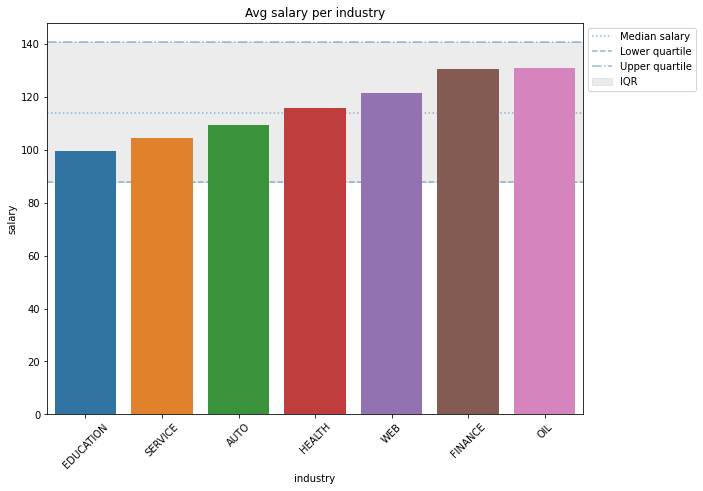

In [40]:
plt.figure()
salary_per_category_plot('industry', avg_salary_per_industry)
salary_stats.plot_IQR()
plt.show()

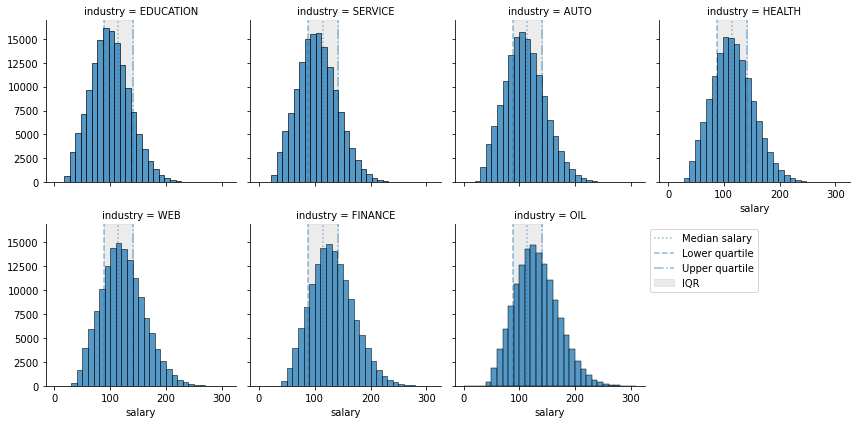

In [42]:
faceted_histogram_plot(salaries_all, 'industry',
                       grid_kwargs = {'col_wrap': 4, 'col_order': avg_salary_per_industry.industry},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per job and degree

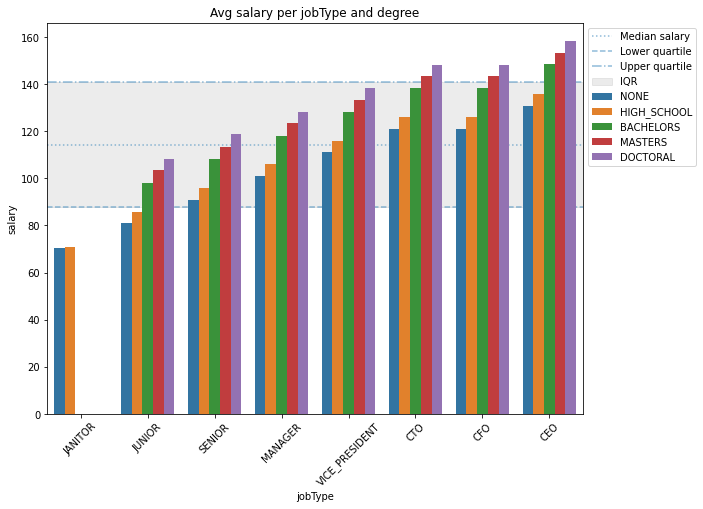

In [38]:
salary_per_degree_and_jobtype = salary_per_category_table(['jobType', 'degree'], salaries_all)

plt.figure()
salary_per_category_plot(['jobType', 'degree'], salary_per_degree_and_jobtype)
salary_stats.plot_IQR()
plt.show()

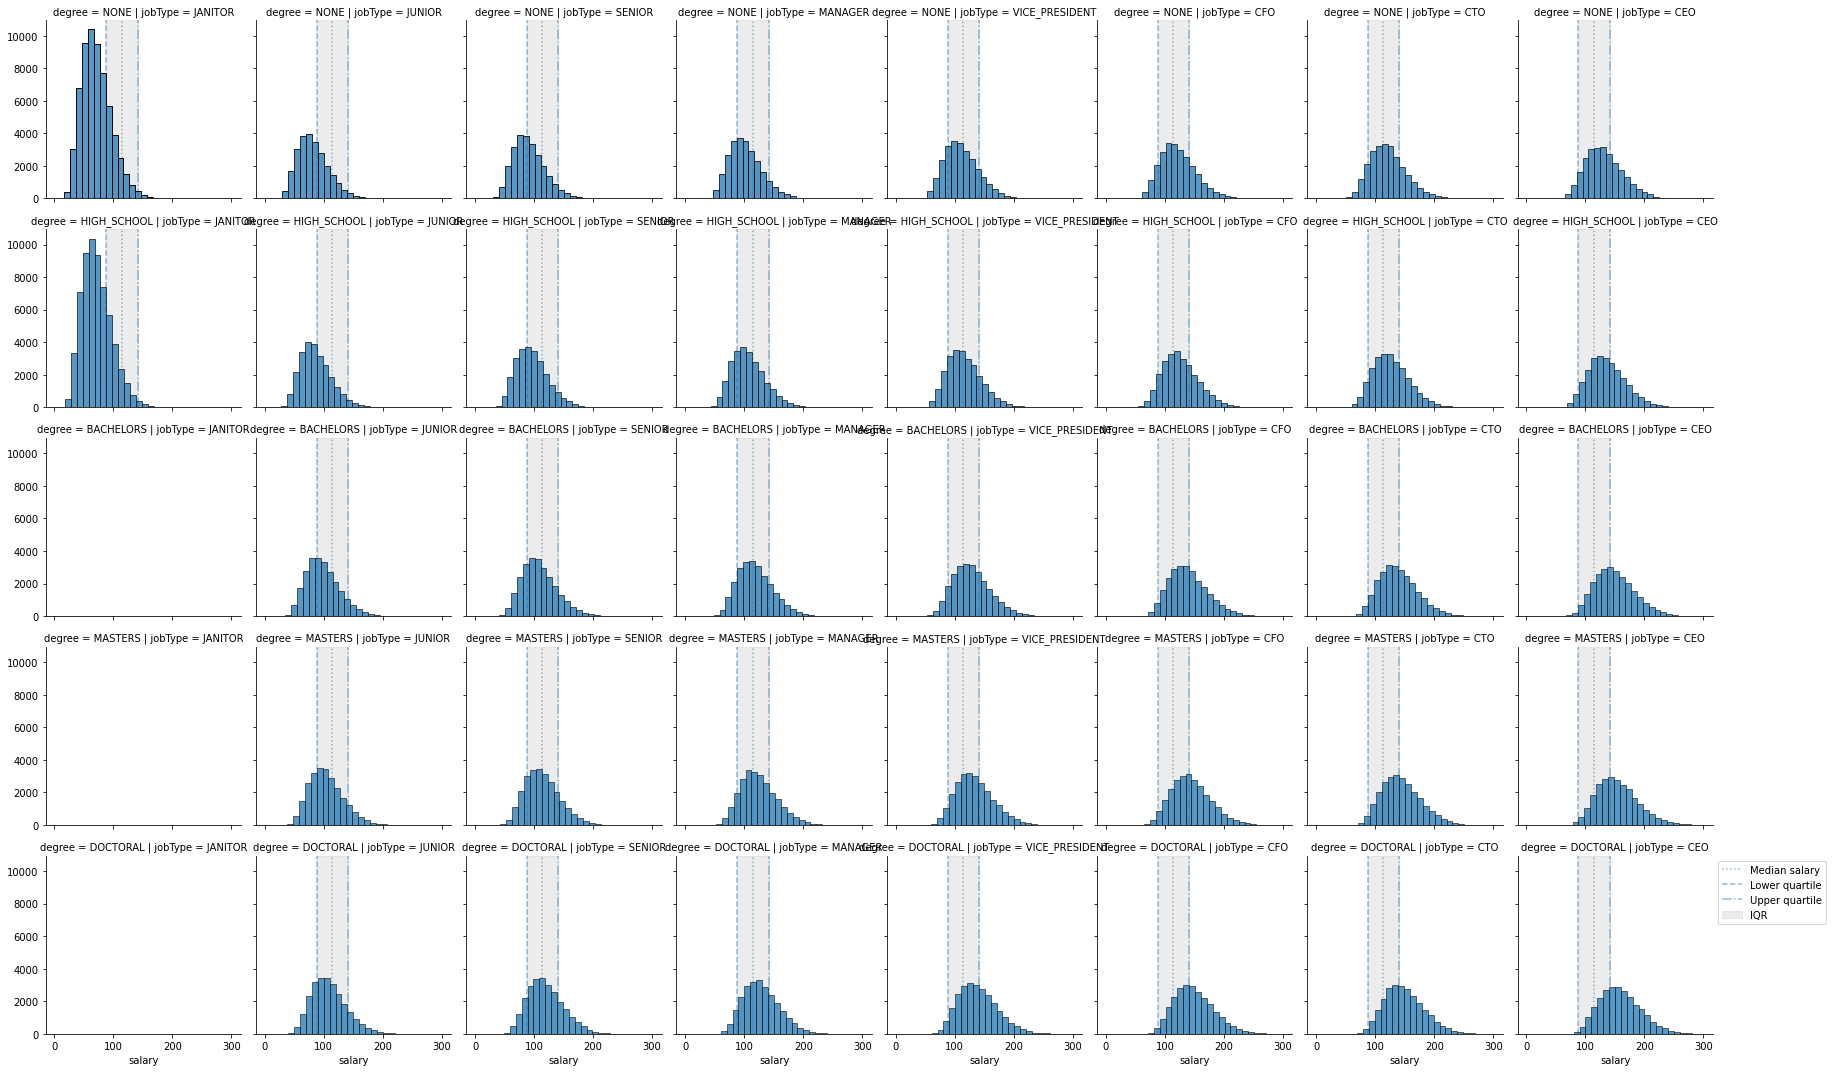

In [46]:
faceted_histogram_plot(salaries_all, 'jobType',
                       grid_kwargs = {'row': 'degree', 'col_order': avg_salary_per_jobtype.jobType, 'row_order': avg_salary_per_degree.degree},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per job and industry

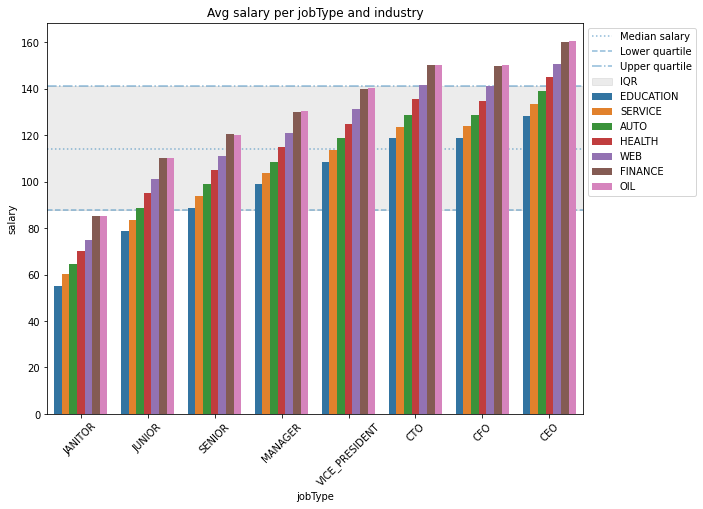

In [47]:
salary_per_jobtype_and_industry = salary_per_category_table(['jobType', 'industry'], salaries_all)

plt.figure()
salary_per_category_plot(['jobType', 'industry'], salary_per_jobtype_and_industry)
salary_stats.plot_IQR()
plt.show()

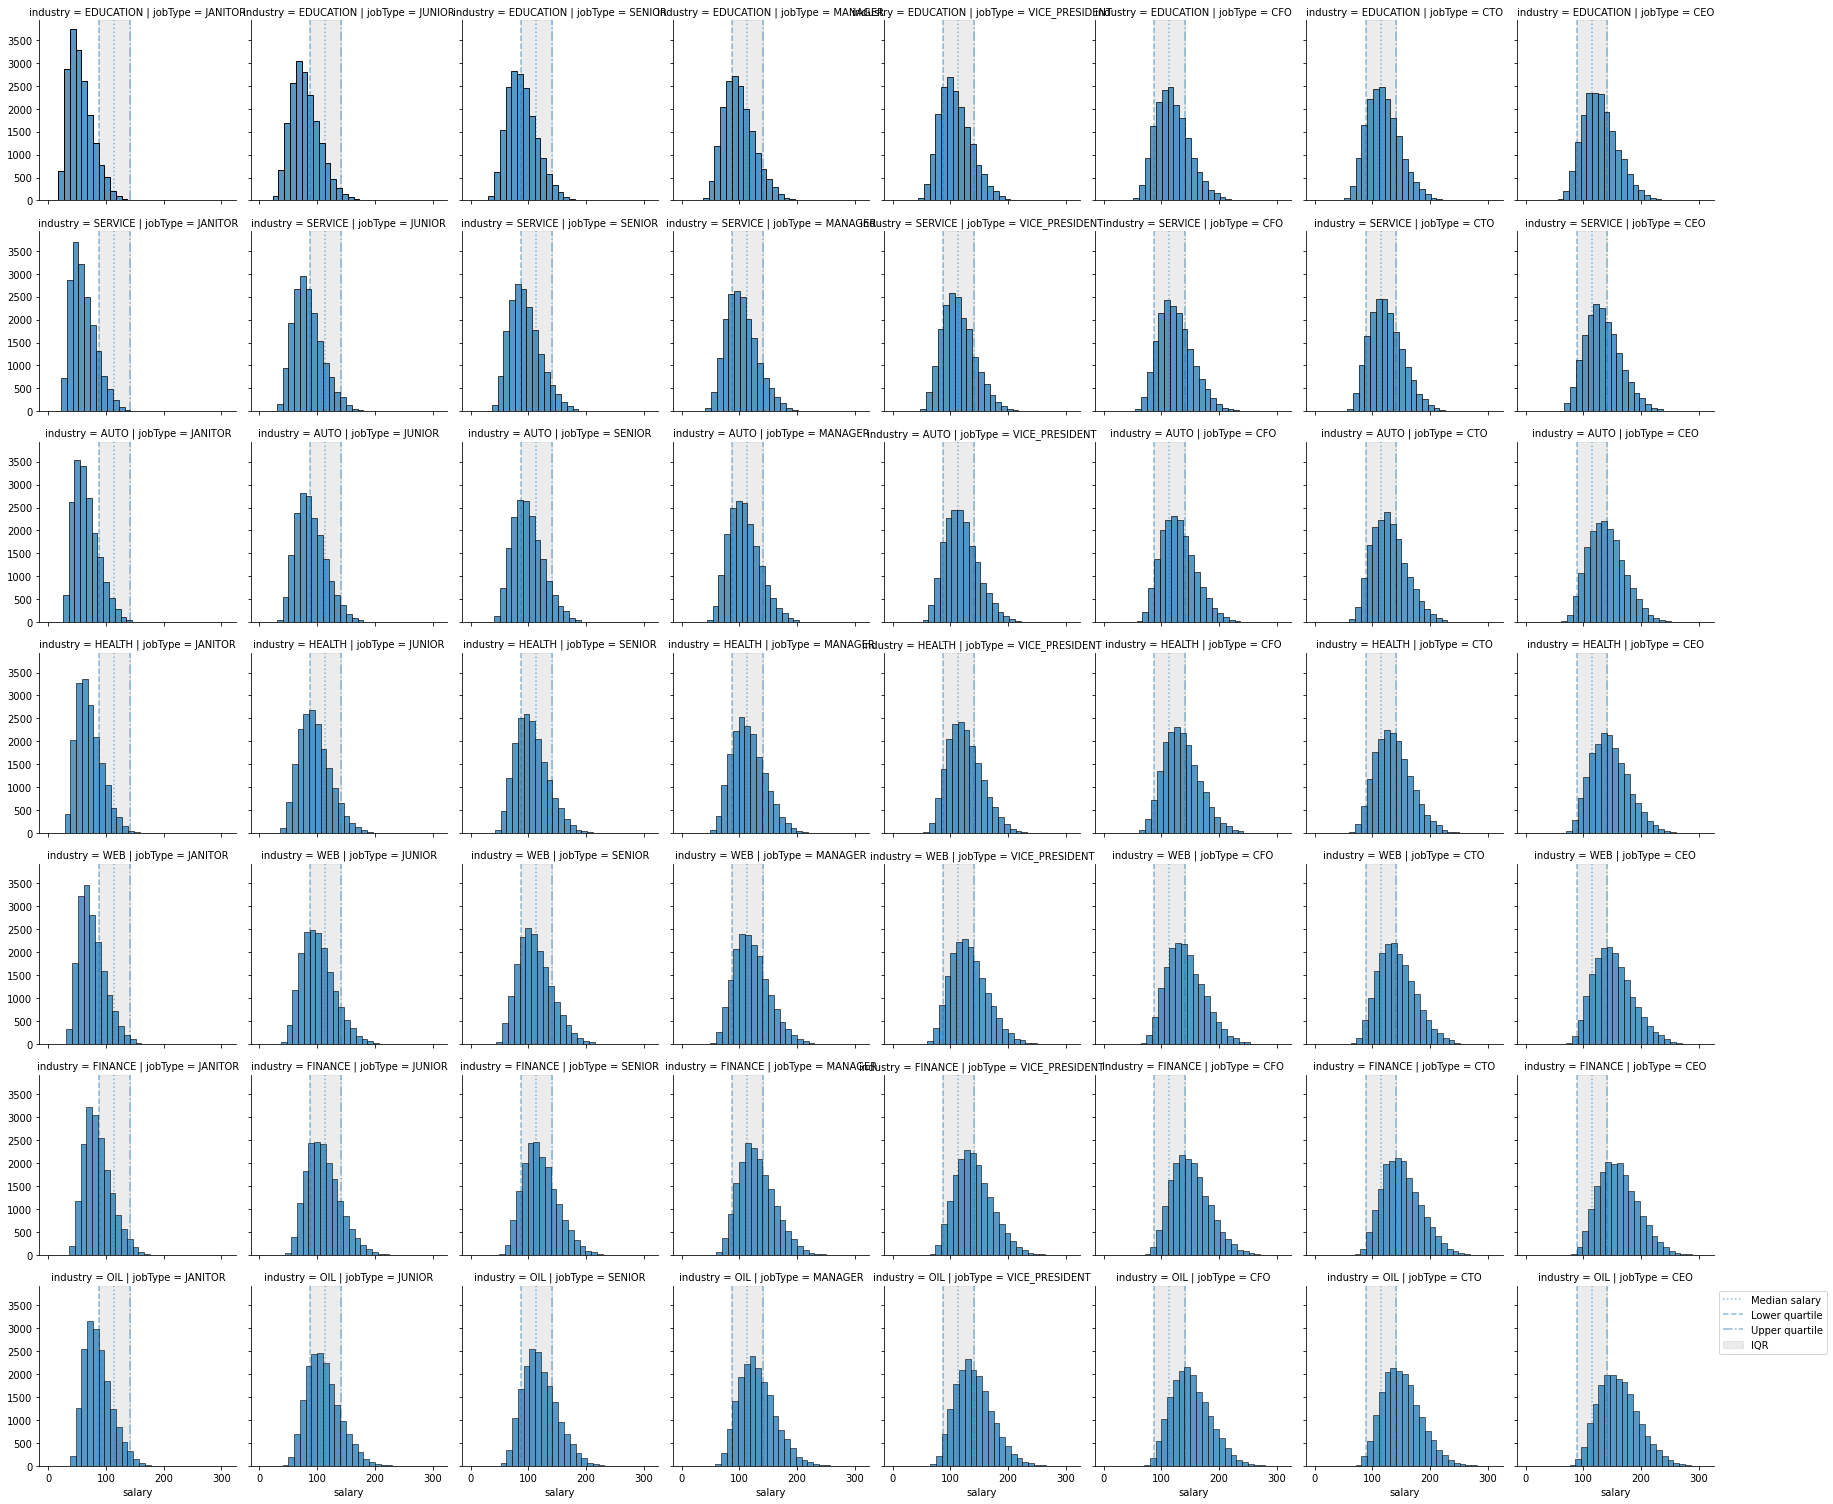

In [48]:
faceted_histogram_plot(salaries_all, 'jobType',
                       grid_kwargs = {'row': 'industry', 'col_order': avg_salary_per_jobtype.jobType, 'row_order': avg_salary_per_industry.industry},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per job and major

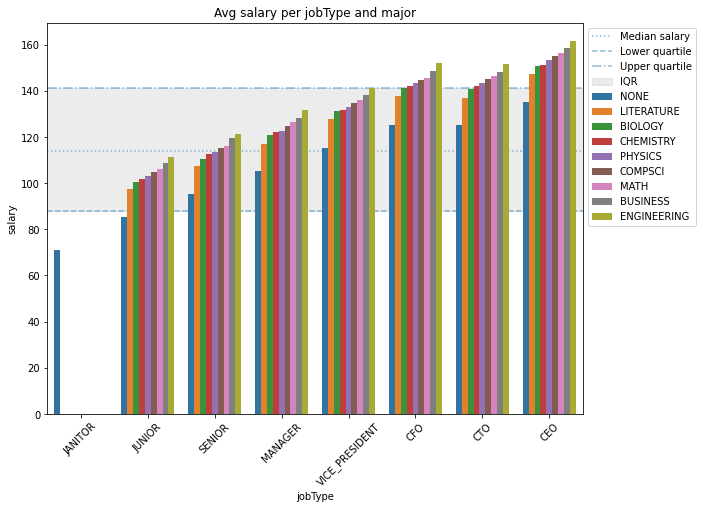

In [40]:
salary_per_job_and_major = salary_per_category_table(['jobType', 'major'], salaries_all)

plt.figure()
salary_per_category_plot(['jobType', 'major'], salary_per_job_and_major)
salary_stats.plot_IQR()
plt.show()

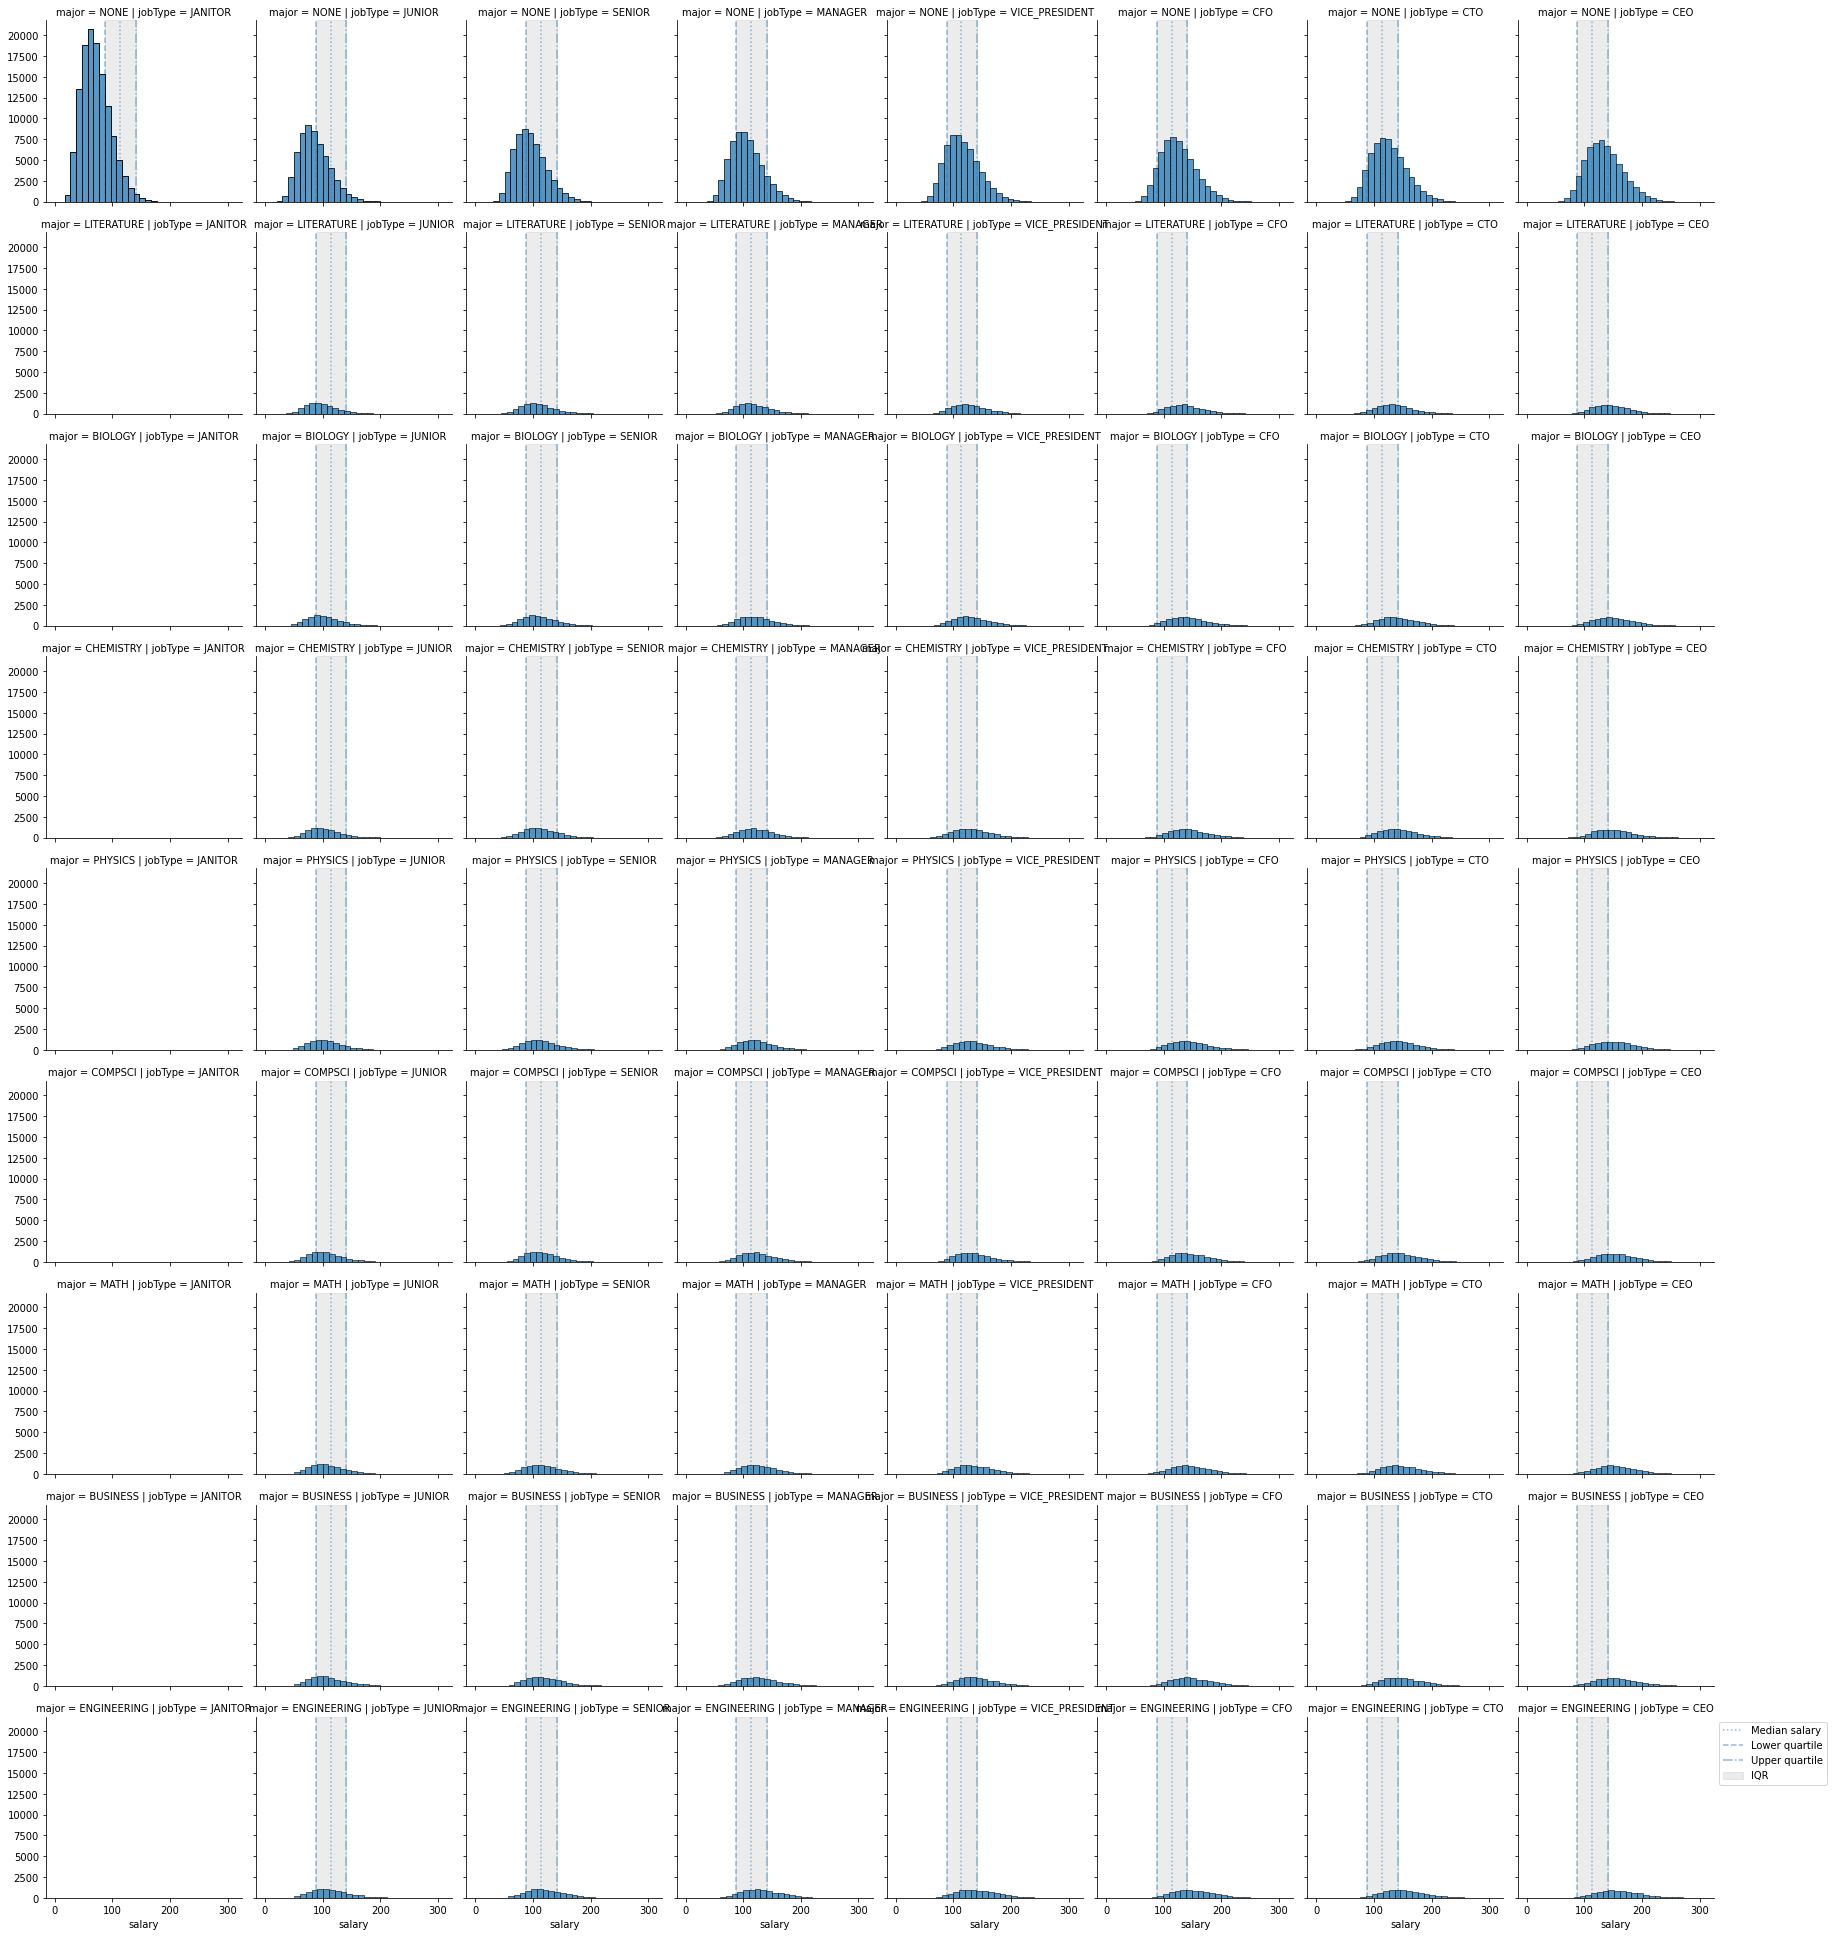

In [49]:
faceted_histogram_plot(salaries_all, 'jobType',
                       grid_kwargs = {'row': 'major', 'col_order': avg_salary_per_jobtype.jobType, 'row_order': avg_salary_per_major.major},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per degree and major

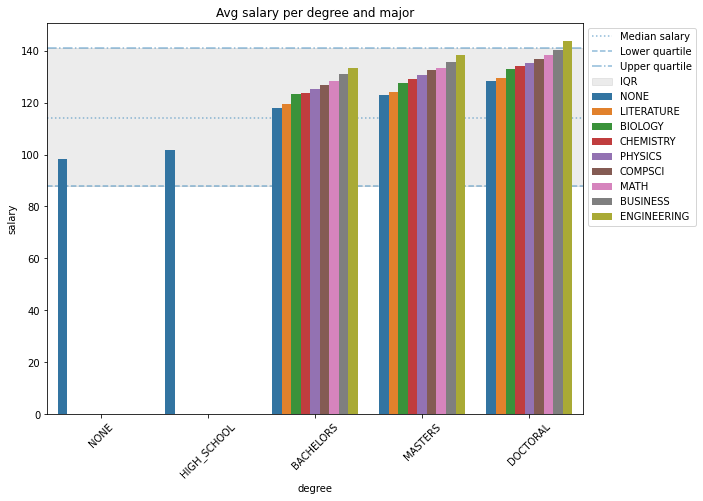

In [51]:
salary_per_major_and_degree = salary_per_category_table(['degree', 'major'], salaries_all)

plt.figure()
salary_per_category_plot(['degree', 'major'], salary_per_major_and_degree)
salary_stats.plot_IQR()
plt.show()

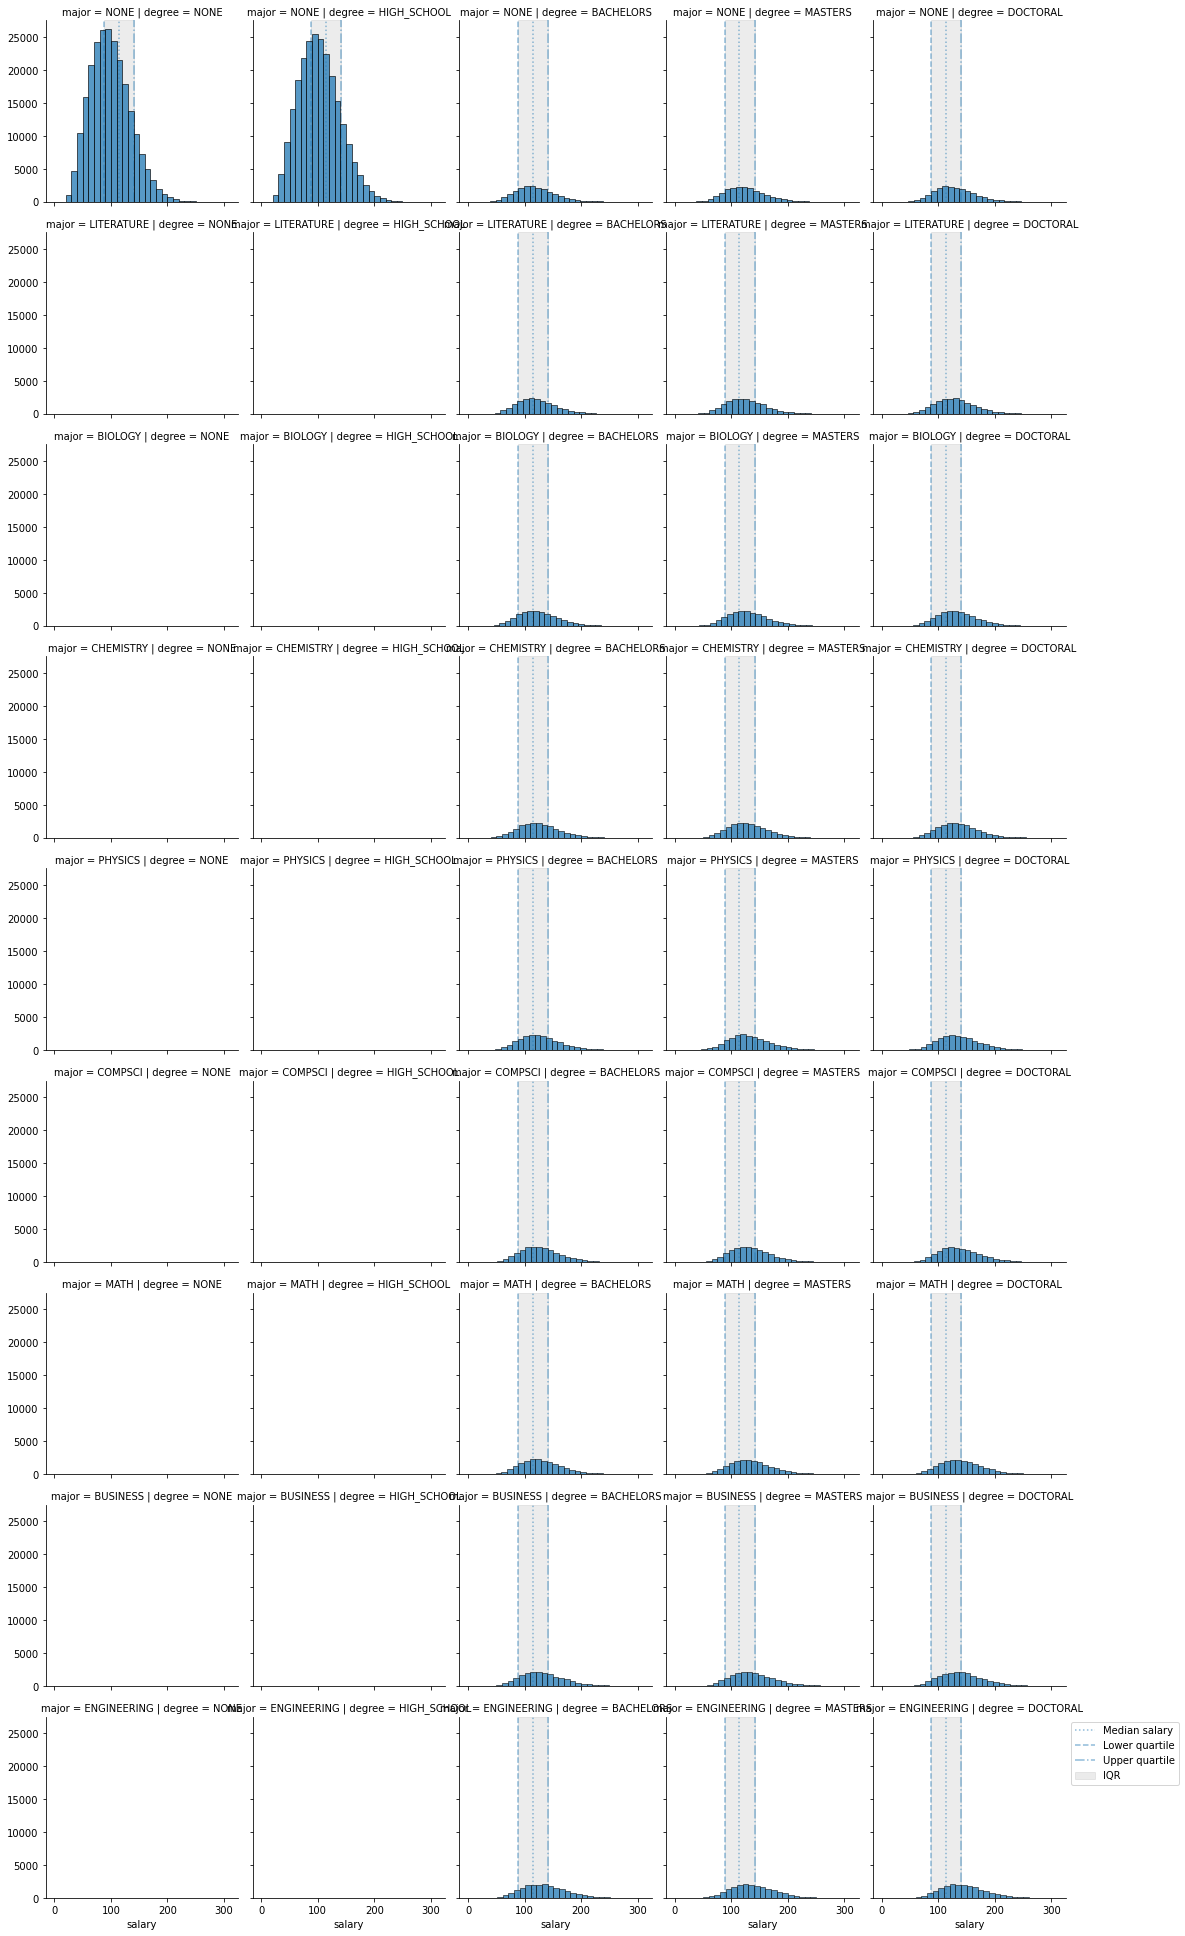

In [52]:
faceted_histogram_plot(salaries_all, 'degree',
                       grid_kwargs = {'row': 'major', 'col_order': avg_salary_per_degree.degree, 'row_order': avg_salary_per_major.major},
                       plot_kwargs = {'binwidth': 10, 'plot_stats': salary_stats})

## Salaries per degree and industry

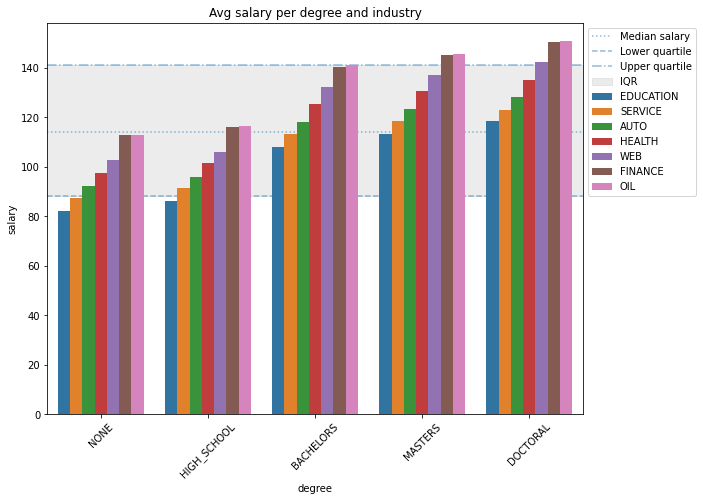

In [54]:
salary_per_degree_and_industry = salary_per_category_table(['degree', 'industry'], salaries_all)

plt.figure()
salary_per_category_plot(['degree', 'industry'], salary_per_degree_and_industry)
salary_stats.plot_IQR()
plt.show()

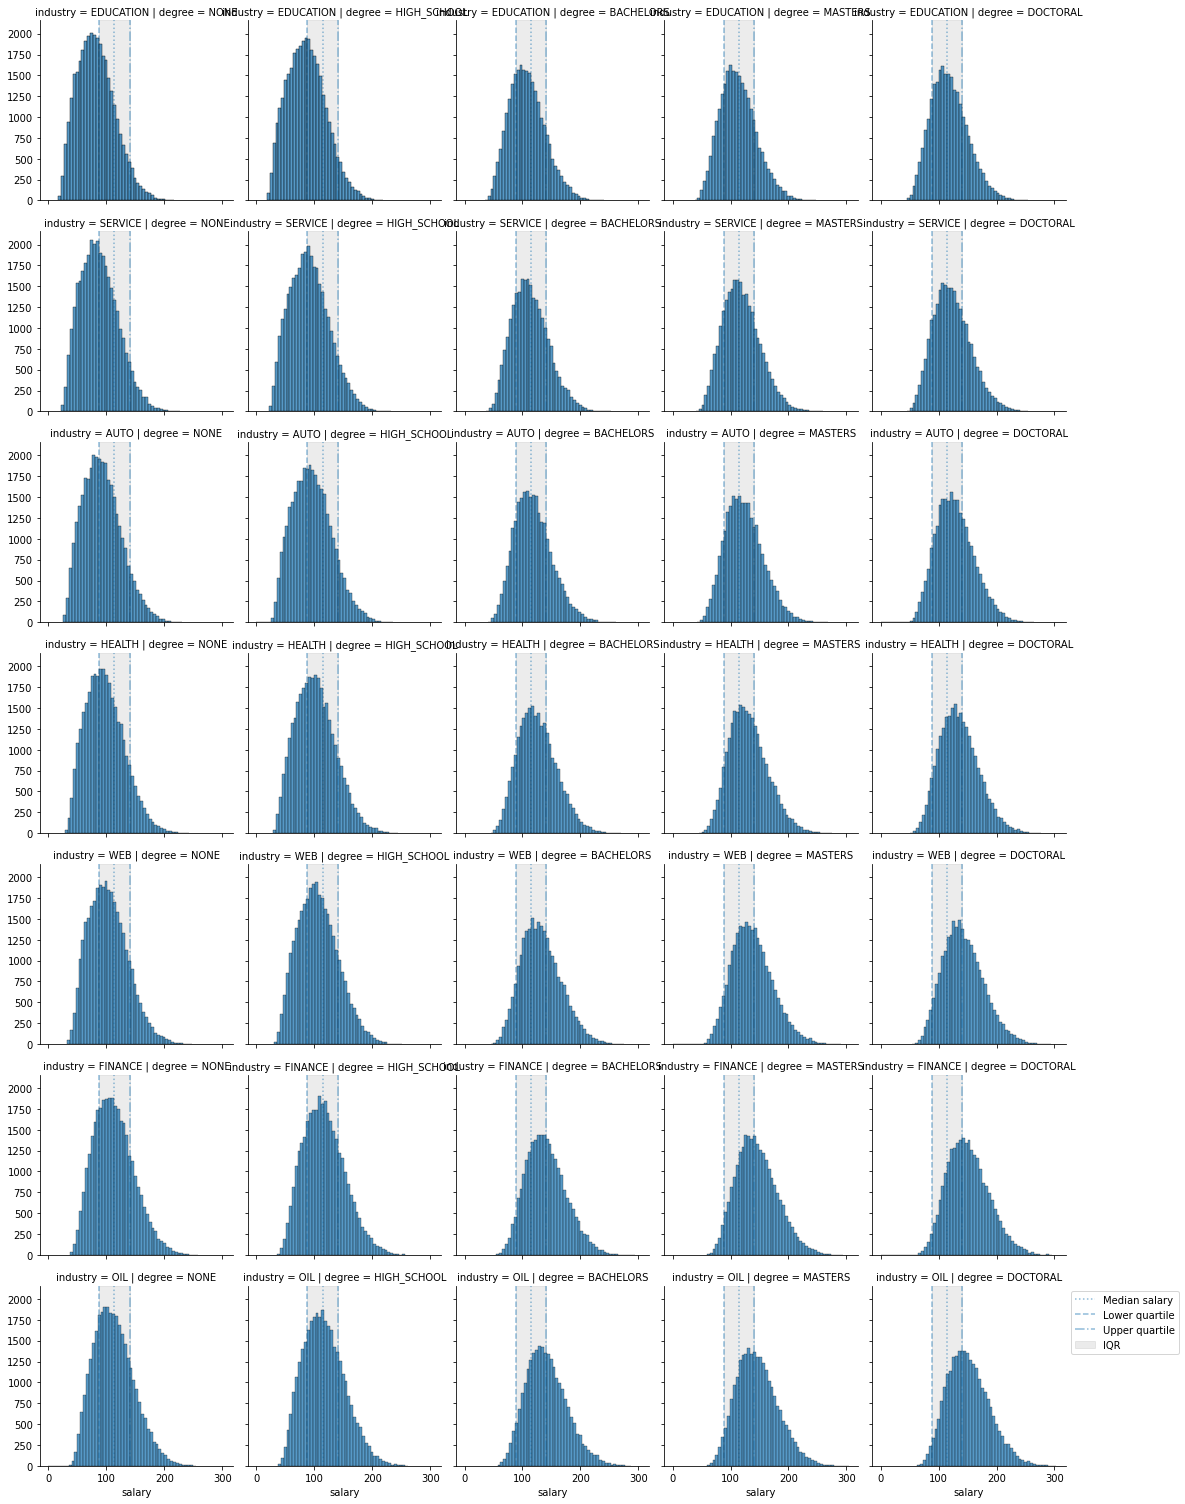

In [59]:
faceted_histogram_plot(salaries_all, 'degree',
                       grid_kwargs = {'row': 'industry', 'col_order': avg_salary_per_degree.degree, 'row_order': avg_salary_per_industry.industry},
                       plot_kwargs = {'binwidth': 5, 'plot_stats': salary_stats})

## Salaries per industry and major 

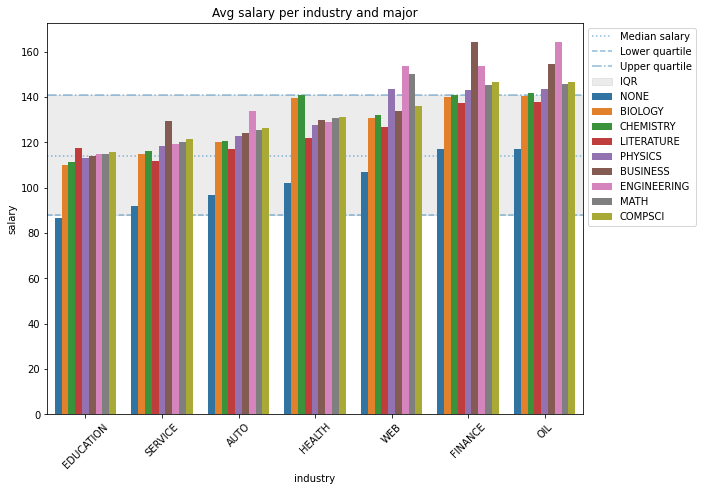

In [62]:
salary_per_industry_and_major = salary_per_category_table(['industry', 'major'], salaries_all)

plt.figure()
salary_per_category_plot(['industry', 'major'], salary_per_industry_and_major)
salary_stats.plot_IQR()
plt.show()

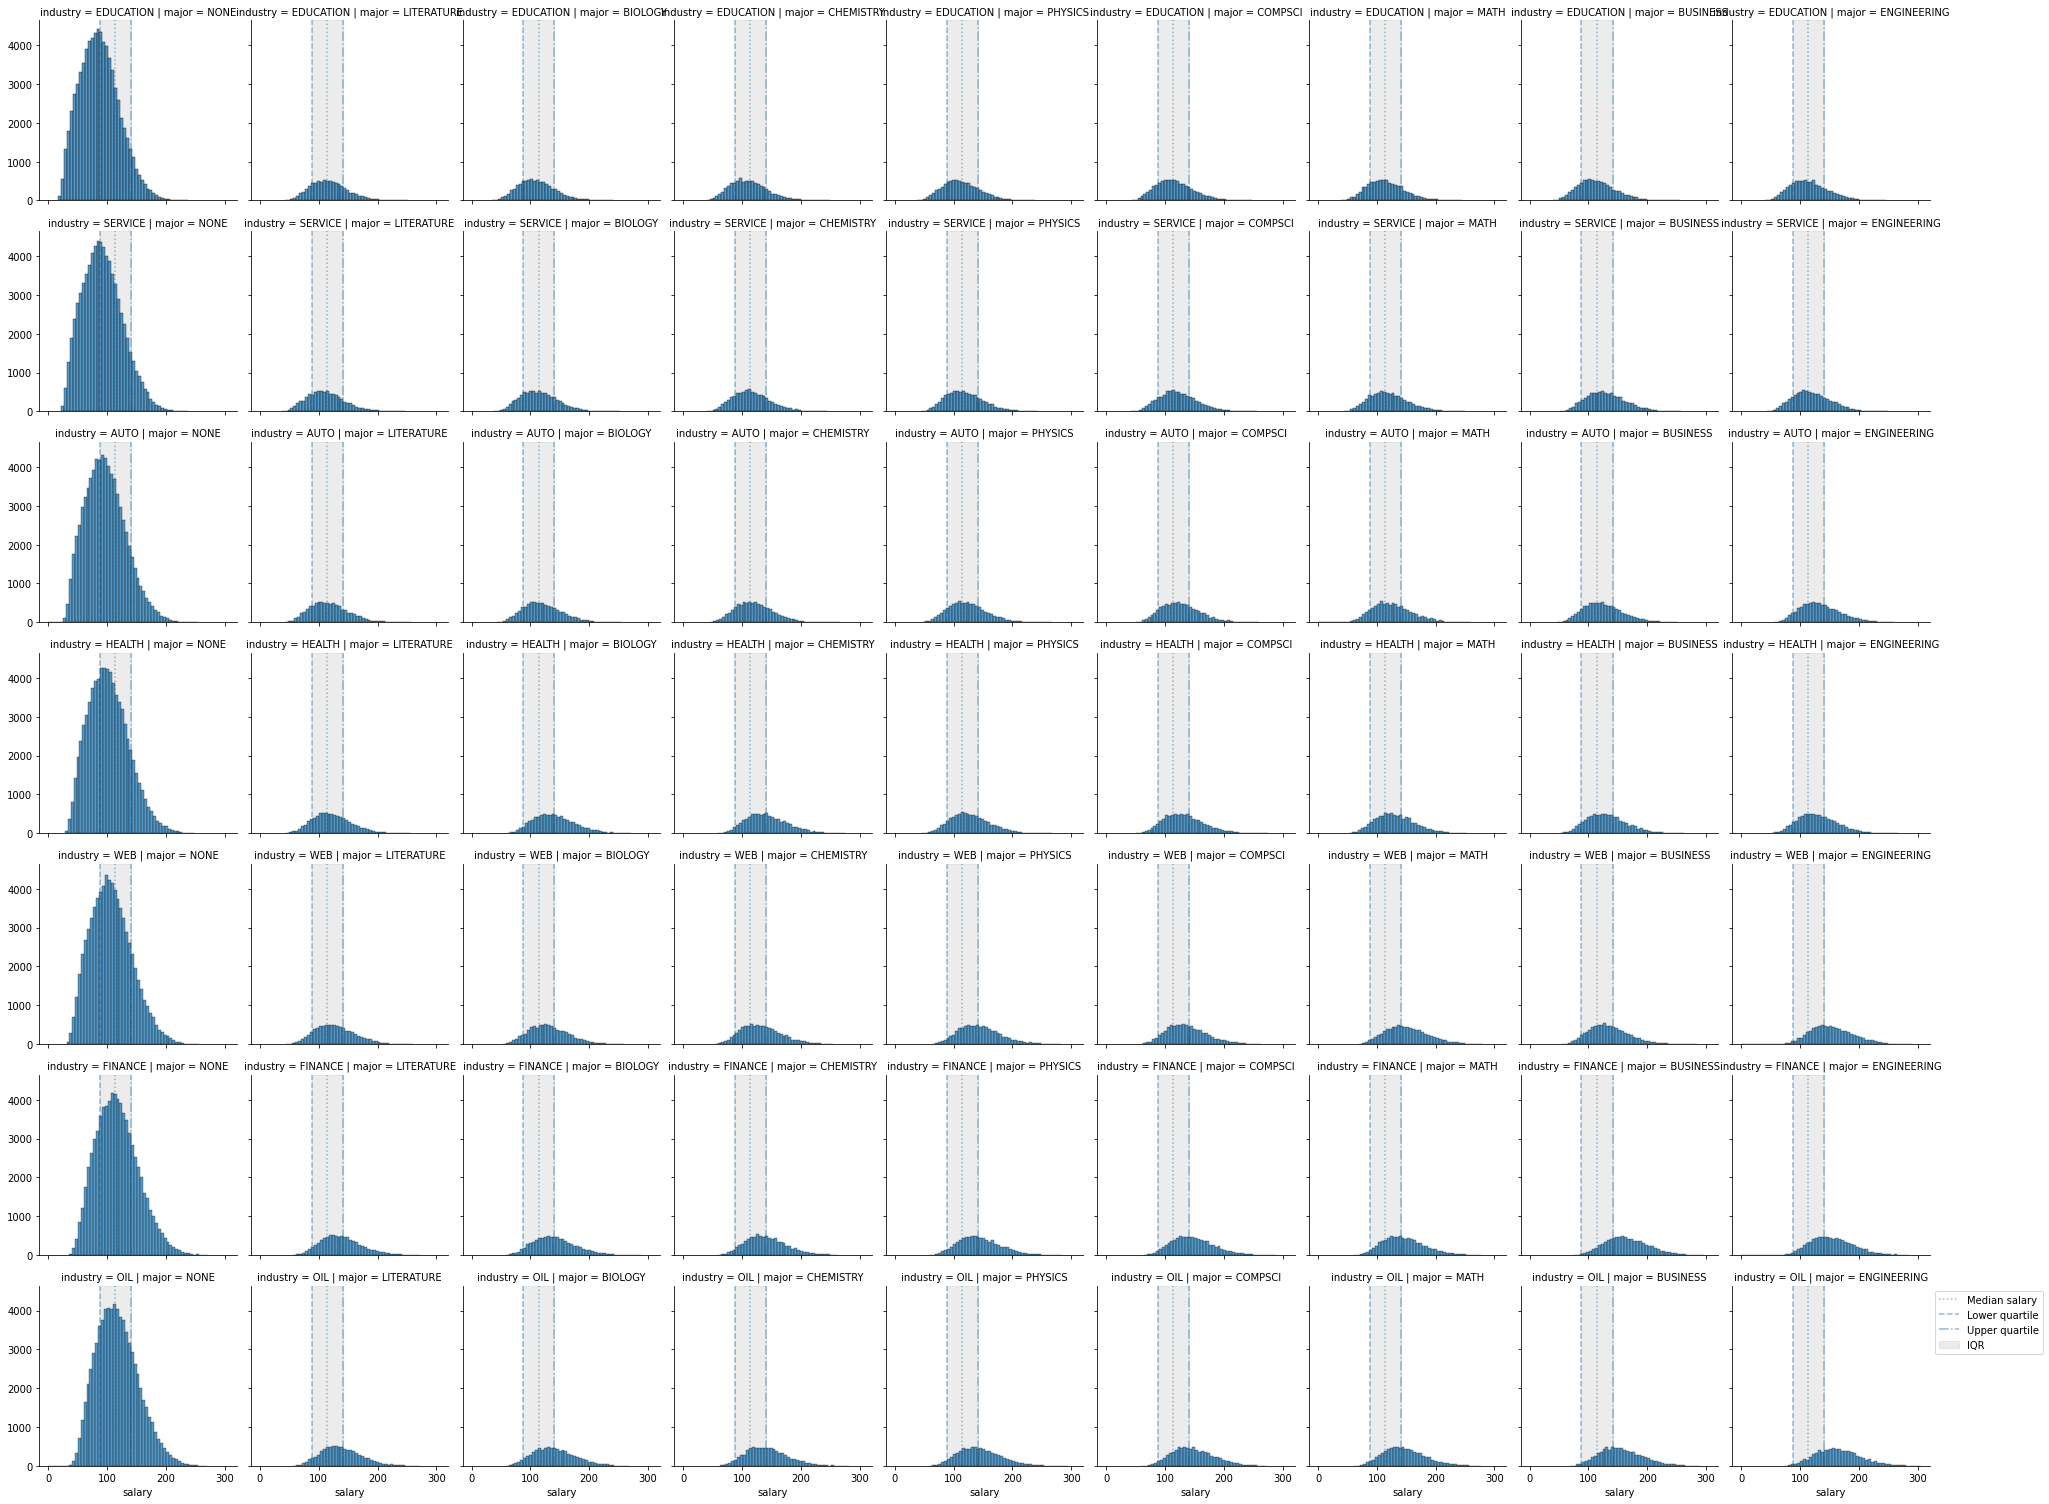

In [64]:
faceted_histogram_plot(salaries_all, 'major',
                       grid_kwargs = {'row': 'industry', 'col_order': avg_salary_per_major.major, 'row_order': avg_salary_per_industry.industry},
                       plot_kwargs = {'binwidth': 5, 'plot_stats': salary_stats})

# Continuous Features

## Miles from metropolis

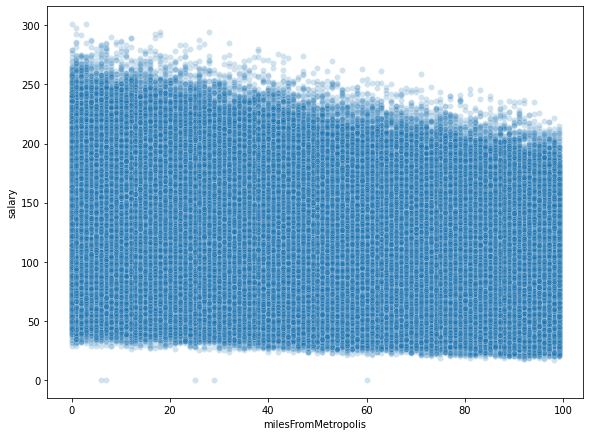

In [41]:
sns.scatterplot(x = salaries_all.milesFromMetropolis, y = salaries_all.salary, alpha = 0.2)
plt.show()

In [42]:
avg_salary_per_distance = salaries_all.groupby('milesFromMetropolis').salary.mean()

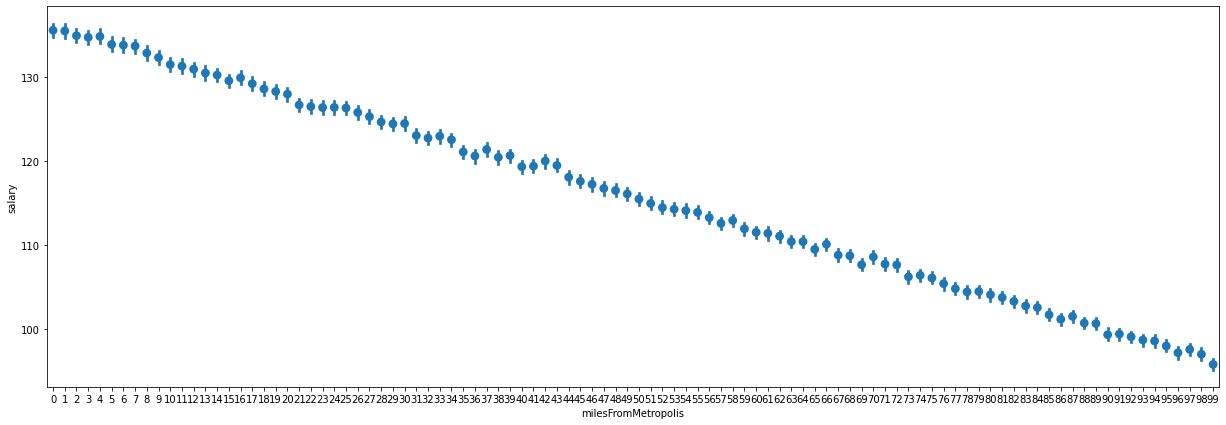

In [43]:
plt.figure(figsize = (21,7))
sns.pointplot(x = salaries_all.milesFromMetropolis, y = salaries_all.salary, join = False)
plt.show()

F:\Code\Data Science Projects\salary_prediction\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


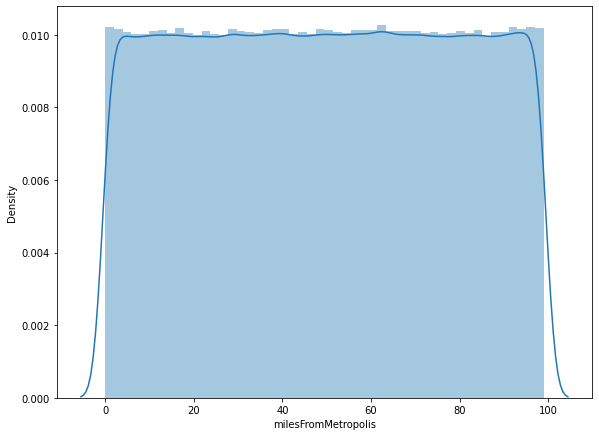

In [44]:
sns.distplot(salaries_all.milesFromMetropolis)
plt.show()

## Years of experience

There are a handful of instances with 0 salary.

These could be outliers, errors in the data or they could even be typical (although rare) examples that we could expect in future real world examples. More context about how the upstream data pipeline would be useful information for how to handle cases with 0 salary.

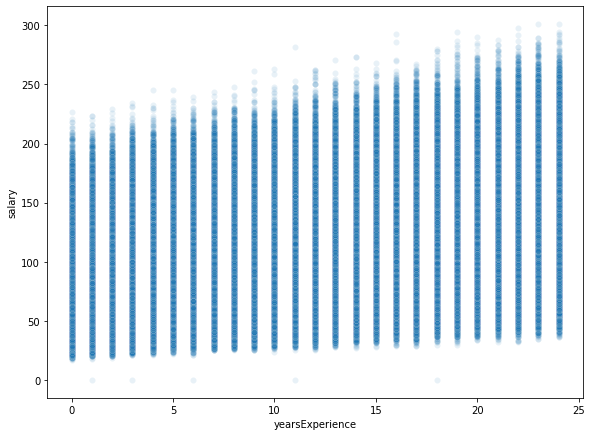

In [45]:
sns.scatterplot(x = salaries_all.yearsExperience, y = salaries_all.salary, alpha = 0.1)
plt.show()

F:\Code\Data Science Projects\salary_prediction\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


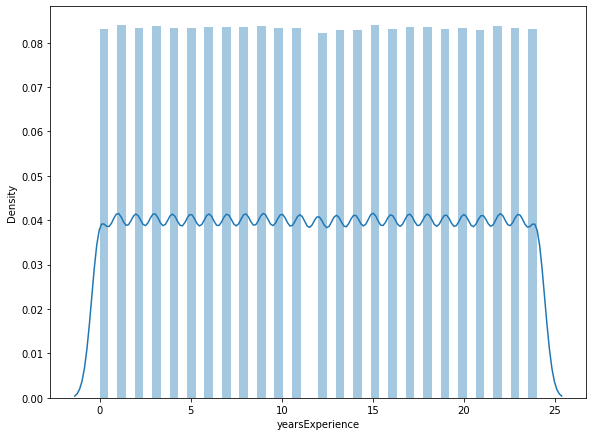

In [46]:
sns.distplot(salaries_all.yearsExperience)
plt.show()